# NOAA Multi-Radar / Multi-Sensor System (MRMS) - Hourly QPE Comparison

The [NOAA Multi-Radar / Multi-Sensor System (MRMS)](https://www.nssl.noaa.gov/projects/mrms/) was created to produce products of preciptiation impacts on transportation and aviation. 

Using the [NOAA MRMS AWS Bucket](https://aws.amazon.com/marketplace/pp/prodview-6odvdc4md2jjc), this notebook details creation of quicklooks to investigate a three-dimensional mosaic for Chicago. 

In [40]:
import cfgrib
import xarray as xr
import fsspec
import glob
import tempfile
import io
import gzip
import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from cartopy import crs as ccrs, feature as cfeature
from cartopy.io.img_tiles import GoogleTiles, OSM
from matplotlib.transforms import offset_copy
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

from metpy.plots import USCOUNTIES

import cmweather
import sage_data_client

## Default Configuration

In [41]:
# Define a Date for Analysis [YYYYMMDD format]
DATE = "20250425"
##TIME = "130039" + "*"
TIME = ""
HOUR = "000000"

In [42]:
# Site attributes
global_NEIU = {'conventions': "CF 1.10",
               'site_ID' : "NEIU",
               'CAMS_tag' : "CMS-WXT-002",
               'datastream' : "CMS_wxt536_NEIU_a1",
               'datalevel' : "a1",
               "wxt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
               "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
               'WSN' : 'W08D',
               'latitude' : 41.9804526,
               'longitude' : -87.7196038}
    
global_NU = {'conventions': "CF 1.10",
             'WSN':'W099',
             'site_ID' : "NU",
             'CAMS_tag' : "CMS-WXT-005",
             'datastream' : "CMS_wxt536_NU_a1",
             'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
             "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
             'datalevel' : "a1",
             'latitude' : 42.051469749,
             'longitude' : -87.677667183}
    
global_CSU = {'conventions': "CF 1.10",
              'WSN':'W08E',
              'site_ID' : "CSU",
              'CAMS_tag' : "CMS-WXT-003",
              'datastream' : "CMS_wxt536_CSU_a1",
              'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
              "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
              'datalevel' : "a1",
              'latitude' : 41.71991216,
              'longitude' : -87.612834722}
    
global_UIC = {'conventions': "CF 1.10",
              'WSN':'W096',
              'site_ID' : "UIC",
              'CAMS_tag' : "CMS-WXT-006",
              'datastream' : "CMS_wxt536_UIC_a1",
              'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
              "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
              'datalevel' : "a1",
              'latitude' : 41.86943346,
              'longitude' : -87.645337665}
    
global_ATMOS = {'conventions': "CF 1.10",
                'WSN':'W0A4',
                'site_ID' : "ATMOS",
                'CAMS_tag' : "CMS-WXT-001",
                'datastream' : "CMS_wxt536_ATMOS_a1",
                'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
                'datalevel' : "a1",
                'latitude' : 41.701556533,
                'longitude' : -87.99507543}
    
global_CCICS = {'conventions': "CF 1.10",
                'WSN':'W08B',
                'site_ID' : "CCICS",
                'CAMS_tag' : "CMS-WXT-099",
                'datastream' : "CMS_wxt536_CCICS_a1",
                'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
                'datalevel' : "a1",
                'latitude' : 41.822953674,
                'longitude' : -87.609452418}

global_BIG   = {'conventions': "CF 1.10",
                    'WSN':'W0A0',
                    'site_ID' : "BIG",
                    'CAMS_tag' : "CMS-WXT-014",
                    'datastream' : "CMS_wxt536_BIG_a1",
                    'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                    "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
                    'datalevel' : "a1",
                    'latitude' : 41.777009821,
                    'longitude' : -87.609746965}
    
global_HUM  =  {'conventions': "CF 1.10",
                'WSN':'W0A1',
                'site_ID' : "HUM",
                'CAMS_tag' : "CMS-WXT-010",
                'datastream' : "CMS_wxt536_HUM_a1",
                'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
                'datalevel' : "a1",
                'latitude' : 41.905513206,
                'longitude' : -87.703525713}
    
global_DOWN = {'conventions': "CF 1.10",
               'WSN':'W09D',
               'site_ID' : "DOWN",
               'CAMS_tag' : "CMS-WXT-008",
               'datastream' : "CMS_wxt536_DOWN_a1",
               'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
               "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
               'datalevel' : "a1",
               'latitude' : 41.795306577,
               'longitude' : -88.006144107}
    
global_SHEDD = {'conventions': "CF 1.10",
                'WSN':'W09E',
                'site_ID' : "SHEDD",
                'CAMS_tag' : "CMS-WXT-007",
                'datastream' : "CMS_wxt536_SHEDD_a1",
                'plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
                'datalevel' : "a1",
                'latitude' : 41.867953617,
                'longitude' : -87.613603892}

global_VILLA = {'conventions': "CF 1.10",
                    'WSN':'W095',
                    'site_ID' : "VLPK",
                    'CAMS_tag' : "CMS-WXT-004",
                    'datastream' : "CMS_wxt536_VLPK_a1",
                    'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                    "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
                    'datalevel' : "a1",
                    'latitude' : 41.884884633495616,
                    'longitude' : -87.97871741056426}

global_midway = {"WSN": "JRO",
                 "site_ID" : "KMDW",
                 "elevation" : 617.0,
                 "latitude": 41.78417,
                 "longitude": -87.75528}

global_ohare = {"WSN": "JRO",
                "site_ID" : "KORD",
                "latitude": 41.97972,
                "longitude": -87.90444}
    
#put these in a dictionary for accessing
global_sites = {'NU' : global_NU, 
                'CSU': global_CSU,
                'NEIU': global_NEIU,
                'UIC': global_UIC,
                'ATMOS': global_ATMOS,
                'CCICS': global_CCICS,
                'BIG': global_BIG,
                'HUM': global_HUM,
                "DOWN": global_DOWN,
                "SHEDD": global_SHEDD,
                "VILLA": global_VILLA,
                "KMDW": global_midway,
                "KORD": global_ohare}

In [43]:
chi_box = [271.9, 272.5, 41.6, 42.15]
lake_box = [271.5, 273.0, 41.5, 42.5]

## Define the S3 Bucket Directories

Note that each elevation level contains it's own file

In [44]:
## Setup the AWS S3 filesystem
fs = fsspec.filesystem("s3", anon=True)

In [45]:
s3_multi_bucket = [f"s3://noaa-mrms-pds/CONUS/MultiSensor_QPE_01H_Pass1_00.00/{DATE}/*.gz"]

In [46]:
s3_pass2_bucket = [f"s3://noaa-mrms-pds/CONUS/MultiSensor_QPE_01H_Pass2_00.00/{DATE}/*.gz"]

In [47]:
s3_radar_bucket = [f"s3://noaa-mrms-pds/CONUS/RadarOnly_QPE_01H_00.00/{DATE}/*[0-9]0000.grib2.gz"]

In [48]:
ds_radar_list = []
ds_multi_list = []
ds_pass2_list = []

In [49]:
for scan in s3_multi_bucket:
    file_path = sorted(fs.glob(scan))
    for mrms in file_path:
        with fs.open(mrms, 'rb') as gzip_file:
            with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
                # Uncompress and read the file
                f.write(gzip.decompress(gzip_file.read()))
                ds = xr.load_dataset(f.name, decode_timedelta=False)
                ds = ds.rename({"unknown" : "multisensor_qpe_1hr"})
                ds["multisensor_qpe_1hr"].attrs["units"] = "mm"
                ds["multisensor_qpe_1hr"].attrs["long_name"] = "Precipitation Accumulation (1-Hr latency)"
                # Subset for the desired bounding box and take out all missing values
                ds = ds.sel(latitude=slice(chi_box[3], chi_box[2]), longitude=slice(chi_box[0], chi_box[1])).where(ds.multisensor_qpe_1hr > 0)
                ds_multi_list.append(ds)

In [ ]:
for scan in s3_radar_bucket:
    file_path = sorted(fs.glob(scan))
    for mrms in file_path:
        with fs.open(mrms, 'rb') as gzip_file:
            with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
                # Uncompress and read the file
                f.write(gzip.decompress(gzip_file.read()))
                ds = xr.load_dataset(f.name, decode_timedelta=False)
                ds = ds.rename({"unknown" : "radar_qpe_1hr"})
                ds["radar_qpe_1hr"].attrs["units"] = "mm"
                ds["radar_qpe_1hr"].attrs["long_name"] = "Precipitation Accumulation"
                 # Subset for the desired bounding box and take out all missing values
                ds = ds.sel(latitude=slice(chi_box[3], chi_box[2]), longitude=slice(chi_box[0], chi_box[1])).where(ds.radar_qpe_1hr > 0)
                ds_radar_list.append(ds)

['noaa-mrms-pds/CONUS/RadarOnly_QPE_01H_00.00/20250425/MRMS_RadarOnly_QPE_01H_00.00_20250425-000000.grib2.gz', 'noaa-mrms-pds/CONUS/RadarOnly_QPE_01H_00.00/20250425/MRMS_RadarOnly_QPE_01H_00.00_20250425-010000.grib2.gz', 'noaa-mrms-pds/CONUS/RadarOnly_QPE_01H_00.00/20250425/MRMS_RadarOnly_QPE_01H_00.00_20250425-020000.grib2.gz', 'noaa-mrms-pds/CONUS/RadarOnly_QPE_01H_00.00/20250425/MRMS_RadarOnly_QPE_01H_00.00_20250425-030000.grib2.gz', 'noaa-mrms-pds/CONUS/RadarOnly_QPE_01H_00.00/20250425/MRMS_RadarOnly_QPE_01H_00.00_20250425-040000.grib2.gz', 'noaa-mrms-pds/CONUS/RadarOnly_QPE_01H_00.00/20250425/MRMS_RadarOnly_QPE_01H_00.00_20250425-050000.grib2.gz', 'noaa-mrms-pds/CONUS/RadarOnly_QPE_01H_00.00/20250425/MRMS_RadarOnly_QPE_01H_00.00_20250425-060000.grib2.gz', 'noaa-mrms-pds/CONUS/RadarOnly_QPE_01H_00.00/20250425/MRMS_RadarOnly_QPE_01H_00.00_20250425-070000.grib2.gz', 'noaa-mrms-pds/CONUS/RadarOnly_QPE_01H_00.00/20250425/MRMS_RadarOnly_QPE_01H_00.00_20250425-080000.grib2.gz', 'noaa-mrm

In [51]:
for scan in s3_pass2_bucket:
    file_path = sorted(fs.glob(scan))
    for mrms in file_path:
        with fs.open(mrms, 'rb') as gzip_file:
            with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
                # Uncompress and read the file
                f.write(gzip.decompress(gzip_file.read()))
                ds = xr.load_dataset(f.name, decode_timedelta=False)
                ds = ds.rename({"unknown" : "multisensor_qpe_pass2"})
                ds["multisensor_qpe_pass2"].attrs["units"] = "mm"
                ds["multisensor_qpe_pass2"].attrs["long_name"] = "Precipitation Accumulation (2-Hr latency)"
                # Subset for the desired bounding box and take out all missing values
                ds = ds.sel(latitude=slice(chi_box[3], chi_box[2]), longitude=slice(chi_box[0], chi_box[1])).where(ds.multisensor_qpe_pass2 > 0)
                ds_pass2_list.append(ds)

In [52]:
#ds_merged = xr.concat(ds_list, dim="time")
ds_radar_merged = xr.concat(ds_radar_list, dim="time")
ds_multi_merged = xr.concat(ds_multi_list, dim="time")
ds_pass2_merged = xr.concat(ds_pass2_list, dim="time")

In [53]:
ds_merged = xr.merge([ds_radar_merged, ds_multi_merged, ds_pass2_merged])

In [54]:
# Calculate the Cumulative Distribution
radar_cumulative = ds_merged['radar_qpe_1hr'].cumsum(dim='time')
multisensor = ds_merged['multisensor_qpe_1hr'].cumsum(dim="time")
multisensor_pass2 = ds_merged['multisensor_qpe_pass2'].cumsum(dim="time")

ds_merged['cumulative_radar_qpe'] = radar_cumulative
ds_merged["cumulative_radar_qpe"].attrs["units"] = "mm"
ds_merged["cumulative_radar_qpe"].attrs["long_name"] = "Precipitation Accumulation"

ds_merged['cumulative_multisensor'] = multisensor
ds_merged["cumulative_multisensor"].attrs["units"] = "mm"
ds_merged["cumulative_multisensor"].attrs["long_name"] = "Precipitation Accumulation (1-Hr latency)"

ds_merged['cumulative_ms_pass2'] = multisensor_pass2
ds_merged["cumulative_ms_pass2"].attrs["units"] = "mm"
ds_merged["cumulative_ms_pass2"].attrs["long_name"] = "Precipitation Accumulation (2-Hr latency)"

In [55]:
ds_merged

<xarray.Dataset> Size: 2MB
Dimensions:                 (time: 24, latitude: 55, longitude: 60)
Coordinates:
  * latitude                (latitude) float64 440B 42.15 42.14 ... 41.62 41.61
  * longitude               (longitude) float64 480B 271.9 271.9 ... 272.5 272.5
  * time                    (time) datetime64[ns] 192B 2025-04-25 ... 2025-04...
    step                    float64 8B 0.0
    heightAboveSea          float64 8B 0.0
    valid_time              (time) datetime64[ns] 192B 2025-04-25 ... 2025-04...
Data variables:
    radar_qpe_1hr           (time, latitude, longitude) float32 317kB nan ......
    multisensor_qpe_1hr     (time, latitude, longitude) float32 317kB nan ......
    multisensor_qpe_pass2   (time, latitude, longitude) float32 317kB nan ......
    cumulative_radar_qpe    (time, latitude, longitude) float32 317kB 0.0 ......
    cumulative_multisensor  (time, latitude, longitude) float32 317kB 0.0 ......
    cumulative_ms_pass2     (time, latitude, longitude) float32 317kB 0.0 ......
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceanic and Atmospheric Research
    history:                 2025-05-07T13:27 GRIB to CDM+CF via cfgrib-0.9.1...

## Multi-Panel QPE Display

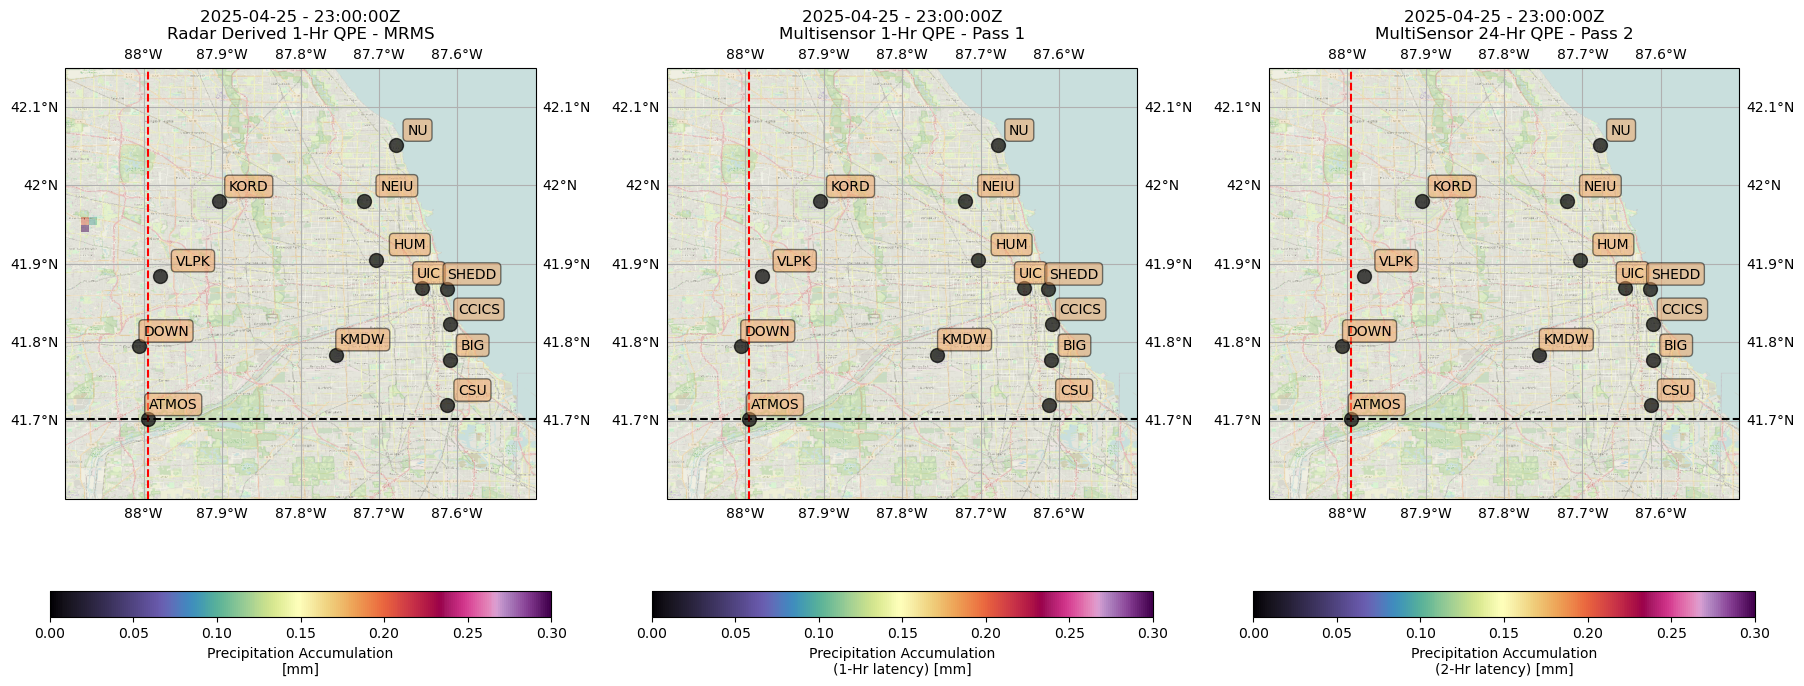

In [56]:
#---------------------------------------------------
# Define the GridSpec for Detailed Subplot Placement
#---------------------------------------------------
fig = plt.figure(figsize=(22, 8))
tiler = OSM()
mercator = tiler.crs
ax = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())

# Find the maximum value at each position
da_max = ds_merged.isel(time=-1).radar_qpe_1hr.max()

# Find the minimum value at each position
da_min = 0

# ---------------------------------------------
# Display the Radar Precipitation Accumulation
# ---------------------------------------------

## subset the data
ds_merged.isel(time=-1).radar_qpe_1hr.plot(transform=ccrs.PlateCarree(),
                                           ax=ax,
                                           cmap="ChaseSpectral",
                                           vmin=da_min,
                                           vmax=da_max,
                                           cbar_kwargs={"location" : "bottom"})

# Add some various map elements to the plot to make it recognizable.
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS)
ax.add_image(tiler, 12, zorder=1, alpha=0.55)
ax.gridlines(draw_labels=True)

# Set plot bounds
ax.set_extent(chi_box)

# add in crosshairs to indicate the lat/lon slices
ax.axhline(y=global_sites["ATMOS"]["latitude"], color="black", linestyle="--")
ax.axvline(x=global_sites["ATMOS"]["longitude"], color="red", linestyle="--")

# Display the location of the CROCUS nodes
for key in global_sites:
    # Add a marker for the CROCUS sites.
    ax.plot(global_sites[key]['longitude'], 
            global_sites[key]['latitude'], 
            marker='o', 
            color='black', 
            markersize=10, 
            alpha=0.7, 
            transform=ccrs.PlateCarree())

    # Use the cartopy interface to create a matplotlib transform object
    # for the Geodetic coordinate system. We will use this along with
    # matplotlib's offset_copy function to define a coordinate system which
    # translates the text by 25 pixels to the left.
    geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

    # SHEDD and UIC are to close to each other. If UIC, plot to the left.
    if key == "UIC":
        # Add text 25 pixels to the left of the volcano.
        ax.text(global_sites[key]['longitude']-0.07, 
                global_sites[key]['latitude'], 
                global_sites[key]['site_ID'], 
                verticalalignment='center', 
                horizontalalignment='left', 
                transform=text_transform,
                bbox=dict(facecolor='sandybrown', 
                alpha=0.5, 
                boxstyle='round'))
    elif key == "BIG" or key == "NU" or key == "CSU":
        # Add text 25 pixels to the left of the volcano.
        ax.text(global_sites[key]['longitude']-0.05, 
                global_sites[key]['latitude'], 
                global_sites[key]['site_ID'], 
                verticalalignment='center', 
                horizontalalignment='left', 
                transform=text_transform,
                bbox=dict(facecolor='sandybrown', 
                alpha=0.5, 
                boxstyle='round'))
    else:
        # Add text 25 pixels to the left of the volcano.
        ax.text(global_sites[key]['longitude'], 
                global_sites[key]['latitude'], 
                global_sites[key]['site_ID'], 
                verticalalignment='center', 
                horizontalalignment='right', 
                transform=text_transform,
                bbox=dict(facecolor='sandybrown', 
                alpha=0.5, 
                boxstyle='round'))
    
# update the title of the display
ax.set_title(np.datetime_as_string(ds_merged['valid_time'].isel(time=-1).data, unit='s').replace("T", " - ") + 
             "Z\n" + "Radar Derived 1-Hr QPE - MRMS")

# ----------------------------
# Display the Multisensor QPE
# ----------------------------
## subset the data
ax1 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
ds_merged.isel(time=-1).multisensor_qpe_1hr.plot(transform=ccrs.PlateCarree(),
                                                 ax=ax1,
                                                 cmap="ChaseSpectral",
                                                 vmin=da_min,
                                                 vmax=da_max,
                                                 cbar_kwargs={"location" : "bottom"})

# Add some various map elements to the plot to make it recognizable.
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.BORDERS)
ax1.add_image(tiler, 12, zorder=1, alpha=0.55)
ax1.gridlines(draw_labels=True)

# Set plot bounds
ax1.set_extent(chi_box)

# add in crosshairs to indicate the lat/lon slices
ax1.axhline(y=global_sites["ATMOS"]["latitude"], color="black", linestyle="--")
ax1.axvline(x=global_sites["ATMOS"]["longitude"], color="red", linestyle="--")

# Display the location of the CROCUS nodes
for key in global_sites:
    # Add a marker for the CROCUS sites.
    ax1.plot(global_sites[key]['longitude'], 
            global_sites[key]['latitude'], 
            marker='o', 
            color='black', 
            markersize=10, 
            alpha=0.7, 
            transform=ccrs.PlateCarree())

    # Use the cartopy interface to create a matplotlib transform object
    # for the Geodetic coordinate system. We will use this along with
    # matplotlib's offset_copy function to define a coordinate system which
    # translates the text by 25 pixels to the left.
    geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax1)
    text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

    # SHEDD and UIC are to close to each other. If UIC, plot to the left.
    if key == "UIC":
        # Add text 25 pixels to the left of the volcano.
        ax1.text(global_sites[key]['longitude']-0.07, 
                global_sites[key]['latitude'], 
                global_sites[key]['site_ID'], 
                verticalalignment='center', 
                horizontalalignment='left', 
                transform=text_transform,
                bbox=dict(facecolor='sandybrown', 
                alpha=0.5, 
                boxstyle='round'))
    elif key == "BIG" or key == "NU" or key == "CSU":
        # Add text 25 pixels to the left of the volcano.
        ax1.text(global_sites[key]['longitude']-0.05, 
                global_sites[key]['latitude'], 
                global_sites[key]['site_ID'], 
                verticalalignment='center', 
                horizontalalignment='left', 
                transform=text_transform,
                bbox=dict(facecolor='sandybrown', 
                alpha=0.5, 
                boxstyle='round'))
    else:
        # Add text 25 pixels to the left of the volcano.
        ax1.text(global_sites[key]['longitude'], 
                global_sites[key]['latitude'], 
                global_sites[key]['site_ID'], 
                verticalalignment='center', 
                horizontalalignment='right', 
                transform=text_transform,
                bbox=dict(facecolor='sandybrown', 
                alpha=0.5, 
                boxstyle='round'))
    
# update the title of the display
ax1.set_title(np.datetime_as_string(ds_merged['valid_time'].isel(time=-1).data, unit='s').replace("T", " - ") + 
             "Z\n" + "Multisensor 1-Hr QPE - Pass 1")

# ----------------------------
# Display the QPE Difference
# ----------------------------
## subset the data
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
ds_merged.isel(time=-1).multisensor_qpe_pass2.plot(transform=ccrs.PlateCarree(),
                                                   ax=ax3,
                                                   cmap="ChaseSpectral",
                                                   vmin=da_min,
                                                   vmax=da_max,
                                                   cbar_kwargs={"location" : "bottom"})

# Add some various map elements to the plot to make it recognizable.
ax3.add_feature(cfeature.LAND)
ax3.add_feature(cfeature.OCEAN)
ax3.add_feature(cfeature.BORDERS)
ax3.add_image(tiler, 12, zorder=1, alpha=0.55)
ax3.gridlines(draw_labels=True)

# Set plot bounds
ax3.set_extent(chi_box)

# add in crosshairs to indicate the lat/lon slices
ax3.axhline(y=global_sites["ATMOS"]["latitude"], color="black", linestyle="--")
ax3.axvline(x=global_sites["ATMOS"]["longitude"], color="red", linestyle="--")

# Display the location of the CROCUS nodes
for key in global_sites:
    # Add a marker for the CROCUS sites.
    ax3.plot(global_sites[key]['longitude'], 
            global_sites[key]['latitude'], 
            marker='o', 
            color='black', 
            markersize=10, 
            alpha=0.7, 
            transform=ccrs.PlateCarree())

    # Use the cartopy interface to create a matplotlib transform object
    # for the Geodetic coordinate system. We will use this along with
    # matplotlib's offset_copy function to define a coordinate system which
    # translates the text by 25 pixels to the left.
    geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax3)
    text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

    # SHEDD and UIC are to close to each other. If UIC, plot to the left.
    if key == "UIC":
        # Add text 25 pixels to the left of the volcano.
        ax3.text(global_sites[key]['longitude']-0.07, 
                global_sites[key]['latitude'], 
                global_sites[key]['site_ID'], 
                verticalalignment='center', 
                horizontalalignment='left', 
                transform=text_transform,
                bbox=dict(facecolor='sandybrown', 
                alpha=0.5, 
                boxstyle='round'))
    elif key == "BIG" or key == "NU" or key == "CSU":
        # Add text 25 pixels to the left of the volcano.
        ax3.text(global_sites[key]['longitude']-0.05, 
                global_sites[key]['latitude'], 
                global_sites[key]['site_ID'], 
                verticalalignment='center', 
                horizontalalignment='left', 
                transform=text_transform,
                bbox=dict(facecolor='sandybrown', 
                alpha=0.5, 
                boxstyle='round'))
    else:
        # Add text 25 pixels to the left of the volcano.
        ax3.text(global_sites[key]['longitude'], 
                global_sites[key]['latitude'], 
                global_sites[key]['site_ID'], 
                verticalalignment='center', 
                horizontalalignment='right', 
                transform=text_transform,
                bbox=dict(facecolor='sandybrown', 
                alpha=0.5, 
                boxstyle='round'))
    
# update the title of the display
ax3.set_title(np.datetime_as_string(ds_merged['valid_time'].isel(time=-1).data, unit='s').replace("T", " - ") + 
             "Z\n" + "MultiSensor 24-Hr QPE - Pass 2")

plt.savefig("/Users/jrobrien/dev/crocus/figures/mrms-24hr-qpe-example.png")


## Wrap up this work into a function, create gif for entire day

In [57]:
def precip_accum(global_sites, DATE, HOUR, tdelta=1):
    """
    Determine the Precipitation Accumulation of the CROCUS MicroNet
    through comparison of final value of precipitation accumulation vs 
    24 hours prior

    Input
    -----
    global_sites : dict
        Dictionary containing site identifiers and node codes
    DATE : str
        Date of interest in YYYYMMDD defined by the user
    HOUR : str
        Hour of interest in HHMMSS defined by the user
    delta : int
        Number of hours to accumulation precipitation over
    """

    # Define parameters to drop
    drop_list = ["meta.host", 
                 "meta.missing", 
                 "meta.node", 
                 "meta.plugin", 
                 "meta.sensor", 
                 "meta.task", 
                 "meta.units", 
                 "meta.zone", 
                 "meta.job"]
    
    # Define the times between the periods to minimize the amount of data pulled down
    MICRO_END = DATE[0:4] + "-" + DATE[4:6] + "-" + DATE[6:8] + "T" + HOUR[0:2] + ":" + HOUR[2:4] + ":" + HOUR[4:6] + "Z"
    micro_dt_day1_end = datetime.strptime(MICRO_END, "%Y-%m-%dT%H:%M:%SZ")
    # subtract an hour
    micro_dt_day1_start = micro_dt_day1_end - timedelta(seconds=1)
    # subtract the delta
    micro_dt_day0_start = micro_dt_day1_end - timedelta(hours=tdelta)
    micro_dt_day0_end = micro_dt_day1_end - timedelta(hours=tdelta, seconds=-1)

    #------------------
    # End of the period
    #------------------
    # Query all the nodes just for precipitation
    df_end = sage_data_client.query(
    start=micro_dt_day1_start.strftime("%Y-%m-%dT%H:%M:%SZ"),
    end=MICRO_END,
    filter={
        "plugin": "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.24.11.14.*",
        "vsn": "W096|W095|W08E|W08D|W08B|W099|W09D|W09E|W0A0|W0A1|W0A4",
        "name": "wxt.rain.accumulation"
    }
    ).set_index("timestamp")
    # Drop unnesscary stuff
    df_end = df_end.drop(drop_list, axis=1)
    # initialize the dictionary
    day_end = {}
    for site in global_sites:
        try:
            day_end.update({global_sites[site]["site_ID"] : df_end.loc[df_end["meta.vsn"]==global_sites[site]["WSN"]].iloc[[-1], 1].values[0]})
        except:
            day_end.update({global_sites[site]["site_ID"] : "N/A"})

    #---------------------
    # Start of the Period
    #---------------------

    # Query all the nodes just for precipitation
    df_start = sage_data_client.query(
    start=micro_dt_day0_start.strftime("%Y-%m-%dT%H:%M:%SZ"),
    end=micro_dt_day0_end.strftime("%Y-%m-%dT%H:%M:%SZ"),
    filter={
        "plugin": "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.24.11.14.*",
        "vsn": "W096|W095|W08E|W08D|W08B|W099|W09D|W09E|W0A0|W0A1|W0A4",
        "name": "wxt.rain.accumulation"
    }
    ).set_index("timestamp")
    # Drop the uncessary stuff
    df_start = df_start.drop(drop_list, axis=1)
    # put these in a dictionary for accessing
    day_start = {}
    for site in global_sites:
        try:
            day_start.update({global_sites[site]["site_ID"] : df_start.loc[df_start["meta.vsn"]==global_sites[site]["WSN"]].iloc[[-1], 1].values[0]})
        except:
            day_start.update({global_sites[site]["site_ID"] : "N/A"})

    # find the period accumulation by taking the difference
    day_accum = {}
    for site in global_sites:
        try:
            day_accum.update({site : round(day_end[site] - day_start[site], 2)})
        except:
            day_accum.update({site : "N/A"})
    
    return day_accum

In [58]:
hourly_accum = precip_accum(global_sites, DATE, "190000", tdelta=1)

In [59]:
hourly_accum

{'NU': np.float64(13.69),
 'CSU': np.float64(2.27),
 'NEIU': np.float64(7.24),
 'UIC': np.float64(4.64),
 'ATMOS': np.float64(5.28),
 'CCICS': np.float64(3.94),
 'BIG': 'N/A',
 'HUM': np.float64(5.05),
 'DOWN': np.float64(5.42),
 'SHEDD': np.float64(13.75),
 'VILLA': 'N/A',
 'KMDW': 'N/A',
 'KORD': 'N/A'}

In [60]:
def mrms_1hr_qpe(ds_merged, global_sites, accum, da_max=25, da_min=0, outdir="./"):
    """
    Create a display to visualize MRMS 24hr QPE across
     the Chicago-CROCUS domain, marking locations of the nodes,
     and comparing against CoCoRaHS. 

    Input
    -----
    ds_merged - xarray dataset
        MRMS 24hr Multi-Sensor and Radar only QPE, previously uncompressed and merged
    global_sites : dict
        Information that are specific to the CROCUS sites. 
    accum : dict
        Preciptiation Accumulation for the given period for the CROCUS micronet
    da_max : float
        Maximum precipitation accumulation for the period
    da_min : float
        Minimum precipitation accumulation for the period
    outdir : str
        Path to save figure to
    
    Returns
    -------
    status : str
        returns status message
    """
    #---------------------------------------------------
    # Define the Subplot Placement
    #---------------------------------------------------
    fig = plt.figure(figsize=(22, 8))
    tiler = OSM()
    mercator = tiler.crs
    ax = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())

    # Find the maximum value at each position
    ##da_max = ds_merged.radar_qpe_1hr.max()

    # Find the minimum value at each position
    ##da_min = 0

    # ---------------------------------------------
    # Display the Radar Precipitation Accumulation
    # ---------------------------------------------

    ## subset the data
    ds_merged.radar_qpe_1hr.plot(transform=ccrs.PlateCarree(),
                                 ax=ax,
                                 cmap="ChaseSpectral",
                                 vmin=da_min,
                                 vmax=da_max,
                                 cbar_kwargs={"location" : "bottom"})
    
    # Add some various map elements to the plot to make it recognizable.
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS)
    ax.add_image(tiler, 12, zorder=1, alpha=0.55)
    ax.gridlines(draw_labels=True)

    # Set plot bounds
    ax.set_extent(chi_box)

   # Display the location of the CROCUS nodes
    for key in global_sites:
        if key == "KORD" or key == "KMDW":
            # Add a marker for the CROCUS sites.
            ax.plot(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    marker='s', 
                    color='black', 
                    markersize=8, 
                    alpha=0.7, 
                    transform=ccrs.PlateCarree())
        else:
            # Add a marker for the CROCUS sites.
            ax.plot(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    marker='o', 
                    color='black', 
                    markersize=8, 
                    alpha=0.7, 
                    transform=ccrs.PlateCarree())

        # Use the cartopy interface to create a matplotlib transform object
        # for the Geodetic coordinate system. We will use this along with
        # matplotlib's offset_copy function to define a coordinate system which
        # translates the text by 25 pixels to the left.
        geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
        text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

        # SHEDD and UIC are to close to each other. If UIC, plot to the left.
        if key == "UIC":
            # Add text 25 pixels to the left of the volcano.
            ax.text(global_sites[key]['longitude']-0.09, 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
            # add the accumulation figure
            ax.text(global_sites[key]['longitude']-0.14, 
                    global_sites[key]['latitude']-0.04, 
                    accum[key], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='olivedrab', 
                    alpha=0.5, 
                    boxstyle='round'))
        elif key == "BIG" or key == "NU" or key == "CSU":
            # Add text 25 pixels to the left of the volcano.
            ax.text(global_sites[key]['longitude']-0.05, 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
            # Add text 25 pixels to the left of the marker.
            ax.text(global_sites[key]['longitude']-0.10, 
                    global_sites[key]['latitude']-0.045, 
                    accum[key], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='olivedrab', 
                    alpha=0.5, 
                    boxstyle='round'))
        elif key == "HUM" or key == "NEIU" or key == "VLPK":
            # Add text 25 pixels to the left of the volcano.
            ax.text(global_sites[key]['longitude']-0.055, 
                    global_sites[key]['latitude']-0.005, 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
            # Add text 25 pixels to the left of the marker.
            ax.text(global_sites[key]['longitude']-0.12, 
                    global_sites[key]['latitude']-0.04, 
                    accum[key], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='olivedrab', 
                    alpha=0.5, 
                    boxstyle='round'))
        else:
            # Add text 25 pixels to the left of the volcano.
            ax.text(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='right', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
            if key == "KMDW" or key == "KORD":
                continue
            else:
                ax.text(global_sites[key]['longitude']-0.065, 
                        global_sites[key]['latitude']-0.04, 
                        accum[key], 
                        verticalalignment='center', 
                        horizontalalignment='right', 
                        transform=text_transform,
                        bbox=dict(facecolor='olivedrab', 
                        alpha=0.5, 
                        boxstyle='round'))
    
    # update the title of the display
    ax.set_title(np.datetime_as_string(ds_merged['valid_time'].data, unit='s').replace("T", " - ") + 
                 "Z\n" + "Radar Derived 1-Hr QPE - MRMS")

    # ----------------------------
    # Display the Multisensor QPE
    # ----------------------------
    ## subset the data
    ax1 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
    ds_merged.multisensor_qpe_1hr.plot(transform=ccrs.PlateCarree(),
                                      ax=ax1,
                                      cmap="ChaseSpectral",
                                      vmin=da_min,
                                      vmax=da_max,
                                      cbar_kwargs={"location" : "bottom"})

    # Add some various map elements to the plot to make it recognizable.
    ax1.add_feature(cfeature.LAND)
    ax1.add_feature(cfeature.OCEAN)
    ax1.add_feature(cfeature.BORDERS)
    ax1.add_image(tiler, 12, zorder=1, alpha=0.55)
    ax1.gridlines(draw_labels=True)

    # Set plot bounds
    ax1.set_extent(chi_box)

    # Display the location of the CROCUS nodes
    for key in global_sites:
        if key == "KORD" or key == "KMDW":
            # Add a marker for the CROCUS sites.
            ax1.plot(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    marker='s', 
                    color='black', 
                    markersize=8, 
                    alpha=0.7, 
                    transform=ccrs.PlateCarree())
        else:
            # Add a marker for the CROCUS sites.
            ax1.plot(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    marker='o', 
                    color='black', 
                    markersize=8, 
                    alpha=0.7, 
                    transform=ccrs.PlateCarree())

        # Use the cartopy interface to create a matplotlib transform object
        # for the Geodetic coordinate system. We will use this along with
        # matplotlib's offset_copy function to define a coordinate system which
        # translates the text by 25 pixels to the left.
        geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax1)
        text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

        # SHEDD and UIC are to close to each other. If UIC, plot to the left.
        if key == "UIC":
            # Add text 25 pixels to the left of the volcano.
            ax1.text(global_sites[key]['longitude']-0.09, 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
        elif key == "BIG" or key == "NU" or key == "CSU":
            # Add text 25 pixels to the left of the volcano.
            ax1.text(global_sites[key]['longitude']-0.05, 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
        elif key == "HUM" or key == "NEIU" or key == "VLPK":
            # Add text 25 pixels to the left of the volcano.
            ax1.text(global_sites[key]['longitude']-0.055, 
                    global_sites[key]['latitude']-0.005, 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
        else:
            # Add text 25 pixels to the left of the volcano.
            ax1.text(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='right', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
    
    # update the title of the display
    ax1.set_title(np.datetime_as_string(ds_merged['valid_time'].data, unit='s').replace("T", " - ") + 
                  "Z\n" + "Multisensor 1-Hr QPE - Pass 1")

    # ----------------------------
    # Display the QPE Difference
    # ----------------------------
    ## subset the data
    ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
    ds_merged.multisensor_qpe_pass2.plot(transform=ccrs.PlateCarree(),
                                         ax=ax3,
                                         cmap="ChaseSpectral",
                                         vmin=da_min,
                                         vmax=da_max,
                                         cbar_kwargs={"location" : "bottom"})

    # Add some various map elements to the plot to make it recognizable.
    ax3.add_feature(cfeature.LAND)
    ax3.add_feature(cfeature.OCEAN)
    ax3.add_feature(cfeature.BORDERS)
    ax3.add_image(tiler, 12, zorder=1, alpha=0.55)
    ax3.gridlines(draw_labels=True)

    # Set plot bounds
    ax3.set_extent(chi_box)

    # Display the location of the CROCUS nodes
    for key in global_sites:
        if key == "KORD" or key == "KMDW":
            # Add a marker for the CROCUS sites.
            ax3.plot(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    marker='s', 
                    color='black', 
                    markersize=8, 
                    alpha=0.7, 
                    transform=ccrs.PlateCarree())
        else:
            # Add a marker for the CROCUS sites.
            ax3.plot(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    marker='o', 
                    color='black', 
                    markersize=8, 
                    alpha=0.7, 
                    transform=ccrs.PlateCarree())

        # Use the cartopy interface to create a matplotlib transform object
        # for the Geodetic coordinate system. We will use this along with
        # matplotlib's offset_copy function to define a coordinate system which
        # translates the text by 25 pixels to the left.
        geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax3)
        text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

        # SHEDD and UIC are to close to each other. If UIC, plot to the left.
        if key == "UIC":
            # Add text 25 pixels to the left of the volcano.
            ax3.text(global_sites[key]['longitude']-0.09, 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
            # add the accumulation figure
            ax3.text(global_sites[key]['longitude']-0.14, 
                     global_sites[key]['latitude']-0.04, 
                     accum[key], 
                     verticalalignment='center', 
                     horizontalalignment='left', 
                     transform=text_transform,
                     bbox=dict(facecolor='olivedrab', 
                     alpha=0.5, 
                     boxstyle='round'))
        elif key == "BIG" or key == "NU" or key == "CSU":
            # Add text 25 pixels to the left of the volcano.
            ax3.text(global_sites[key]['longitude']-0.05, 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
            # Add text 25 pixels to the left of the marker.
            ax3.text(global_sites[key]['longitude']-0.10, 
                     global_sites[key]['latitude']-0.045, 
                     accum[key], 
                     verticalalignment='center', 
                     horizontalalignment='left', 
                     transform=text_transform,
                     bbox=dict(facecolor='olivedrab', 
                     alpha=0.5, 
                     boxstyle='round'))
        elif key == "HUM" or key == "NEIU" or key == "VLPK":
            # Add text 25 pixels to the left of the volcano.
            ax3.text(global_sites[key]['longitude']-0.055, 
                    global_sites[key]['latitude']-0.005, 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
            # Add text 25 pixels to the left of the marker.
            ax3.text(global_sites[key]['longitude']-0.12, 
                    global_sites[key]['latitude']-0.04, 
                    accum[key], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='olivedrab', 
                    alpha=0.5, 
                    boxstyle='round'))
        else:
            # Add text 25 pixels to the left of the volcano.
            ax3.text(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='right', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
            if key == "KMDW" or key == "KORD":
                continue
            else:
                ax3.text(global_sites[key]['longitude']-0.065, 
                        global_sites[key]['latitude']-0.04, 
                        accum[key], 
                        verticalalignment='center', 
                        horizontalalignment='right', 
                        transform=text_transform,
                        bbox=dict(facecolor='olivedrab', 
                        alpha=0.5, 
                        boxstyle='round'))
    
    # update the title of the display
    ax3.set_title(np.datetime_as_string(ds_merged['valid_time'].data, unit='s').replace("T", " - ") + 
                  "Z\n" + "Multisensor 1-Hr QPE - Pass 2")
    try:
        fig.savefig(outdir + 
                    'mrms-hourly-qpe-' + 
                    np.datetime_as_string(ds_merged['valid_time'].data, unit='s').replace("T", "-").replace(":", "-") +
                    '.png')
        plt.close(fig)
        STATUS = "SUCCESS"
    except:
        STATUS = "FAILURE"

    del fig, ax, ax1, ax3

    return STATUS

In [61]:
hourly_accum = precip_accum(global_sites, DATE, "190000", tdelta=1)

qpe1hr_plot = mrms_1hr_qpe(ds_merged.isel(time=20), global_sites, hourly_accum, outdir="/Users/jrobrien/dev/crocus/data/mrms/hourly/")
#qpe24_plot.savefig(f"/Users/jrobrien/dev/crocus/figures/mrms-24hr-qpe-{DATE}.png")

In [62]:
templocation = tempfile.mkdtemp() + "/"
for i in range(len(ds_merged.time.data)):
    time_pull = pd.to_datetime(str(ds_merged.isel(time=i).time.data)).strftime("%H%M%S")
    hourly_accum = precip_accum(global_sites, DATE, time_pull, tdelta=1)
    qpe1hr_plot = mrms_1hr_qpe(ds_merged.isel(time=i), 
                               global_sites, 
                               hourly_accum, 
                               da_max=ds_merged.radar_qpe_1hr.max(), 
                               da_min=0.0,
                               outdir=templocation)

## Create a GIF of the entire day

In [63]:
from PIL import Image

def create_gif():
    # Define files created and define movie path
    map_images = sorted(glob.glob(templocation + f"/mrms-hourly-qpe*"))
    gif_title = f"mrms-hourly-qpe-" + DATE + ".gif"

    # Check to see if the file exists - if it does, delete it
    if os.path.exists(gif_title):
        os.remove(gif_title)

    # Step 2: Open images using Pillow
    frames = [Image.open(f) for f in map_images]

    # Step 3: Save as GIF with 2.5s per frame
    frames[0].save(
        gif_title,
        save_all=True,
        append_images=frames[1:],
        duration=850,  # Duration in ms
        loop=0          # Loop forever
    )

In [64]:
create_gif()

## Cumulative Preciptiation

In [65]:
def mrms_1hr_cum_qpe(ds_merged, global_sites, accum, da_max=25, da_min=0, outdir="./"):
    """
    Create a display to visualize cumulative 1hr MRMS QPE across
     the Chicago-CROCUS domain, marking locations of the nodes,
     and comparing against CoCoRaHS. 

    Input
    -----
    ds_merged - xarray dataset
        MRMS 24hr Multi-Sensor and Radar only QPE, previously uncompressed and merged
    global_sites : dict
        Information that are specific to the CROCUS sites. 
    accum : dict
        Preciptiation Accumulation for the given period for the CROCUS micronet
    da_max : float
        Maximum precipitation accumulation for the period
    da_min : float
        Minimum precipitation accumulation for the period
    outdir : str
        Path to save figure to
    
    Returns
    -------
    status : str
        returns status message
    """
    #---------------------------------------------------
    # Define the Subplot Placement
    #---------------------------------------------------
    fig = plt.figure(figsize=(22, 8))
    tiler = OSM()
    mercator = tiler.crs
    ax = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())

    # Find the maximum value at each position
    ##da_max = ds_merged.radar_qpe_1hr.max()

    # Find the minimum value at each position
    ##da_min = 0

    # ---------------------------------------------
    # Display the Radar Precipitation Accumulation
    # ---------------------------------------------

    ## subset the data
    ds_merged.cumulative_radar_qpe.plot(transform=ccrs.PlateCarree(),
                                        ax=ax,
                                        cmap="ChaseSpectral",
                                        vmin=da_min,
                                        vmax=da_max,
                                        cbar_kwargs={"location" : "bottom"})
    
    # Add some various map elements to the plot to make it recognizable.
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS)
    ax.add_image(tiler, 12, zorder=1, alpha=0.55)
    ax.gridlines(draw_labels=True)

    # Set plot bounds
    ax.set_extent(chi_box)

   # Display the location of the CROCUS nodes
    for key in global_sites:
        if key == "KORD" or key == "KMDW":
            # Add a marker for the CROCUS sites.
            ax.plot(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    marker='s', 
                    color='black', 
                    markersize=8, 
                    alpha=0.7, 
                    transform=ccrs.PlateCarree())
        else:
            # Add a marker for the CROCUS sites.
            ax.plot(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    marker='o', 
                    color='black', 
                    markersize=8, 
                    alpha=0.7, 
                    transform=ccrs.PlateCarree())

        # Use the cartopy interface to create a matplotlib transform object
        # for the Geodetic coordinate system. We will use this along with
        # matplotlib's offset_copy function to define a coordinate system which
        # translates the text by 25 pixels to the left.
        geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
        text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

        # SHEDD and UIC are to close to each other. If UIC, plot to the left.
        if key == "UIC":
            # Add text 25 pixels to the left of the volcano.
            ax.text(global_sites[key]['longitude']-0.09, 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
            # add the accumulation figure
            ax.text(global_sites[key]['longitude']-0.14, 
                    global_sites[key]['latitude']-0.04, 
                    accum[key], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='olivedrab', 
                    alpha=0.5, 
                    boxstyle='round'))
        elif key == "BIG" or key == "NU" or key == "CSU":
            # Add text 25 pixels to the left of the volcano.
            ax.text(global_sites[key]['longitude']-0.05, 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
            # Add text 25 pixels to the left of the marker.
            ax.text(global_sites[key]['longitude']-0.10, 
                    global_sites[key]['latitude']-0.045, 
                    accum[key], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='olivedrab', 
                    alpha=0.5, 
                    boxstyle='round'))
        elif key == "HUM" or key == "NEIU" or key == "VLPK":
            # Add text 25 pixels to the left of the volcano.
            ax.text(global_sites[key]['longitude']-0.055, 
                    global_sites[key]['latitude']-0.005, 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
            # Add text 25 pixels to the left of the marker.
            ax.text(global_sites[key]['longitude']-0.12, 
                    global_sites[key]['latitude']-0.04, 
                    accum[key], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='olivedrab', 
                    alpha=0.5, 
                    boxstyle='round'))
        else:
            # Add text 25 pixels to the left of the volcano.
            ax.text(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='right', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
            if key == "KMDW" or key == "KORD":
                continue
            else:
                ax.text(global_sites[key]['longitude']-0.065, 
                        global_sites[key]['latitude']-0.04, 
                        accum[key], 
                        verticalalignment='center', 
                        horizontalalignment='right', 
                        transform=text_transform,
                        bbox=dict(facecolor='olivedrab', 
                        alpha=0.5, 
                        boxstyle='round'))
    
    # update the title of the display
    ax.set_title(np.datetime_as_string(ds_merged['valid_time'].data, unit='s').replace("T", " - ") + 
                 "Z\n" + "Radar Derived Cumulative 1-Hr QPE - MRMS")

    # ----------------------------
    # Display the Multisensor QPE
    # ----------------------------
    ## subset the data
    ax1 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
    ds_merged.cumulative_multisensor.plot(transform=ccrs.PlateCarree(),
                                          ax=ax1,
                                          cmap="ChaseSpectral",
                                          vmin=da_min,
                                          vmax=da_max,
                                          cbar_kwargs={"location" : "bottom"})

    # Add some various map elements to the plot to make it recognizable.
    ax1.add_feature(cfeature.LAND)
    ax1.add_feature(cfeature.OCEAN)
    ax1.add_feature(cfeature.BORDERS)
    ax1.add_image(tiler, 12, zorder=1, alpha=0.55)
    ax1.gridlines(draw_labels=True)

    # Set plot bounds
    ax1.set_extent(chi_box)

    # Display the location of the CROCUS nodes
    for key in global_sites:
        if key == "KORD" or key == "KMDW":
            # Add a marker for the CROCUS sites.
            ax1.plot(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    marker='s', 
                    color='black', 
                    markersize=8, 
                    alpha=0.7, 
                    transform=ccrs.PlateCarree())
        else:
            # Add a marker for the CROCUS sites.
            ax1.plot(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    marker='o', 
                    color='black', 
                    markersize=8, 
                    alpha=0.7, 
                    transform=ccrs.PlateCarree())

        # Use the cartopy interface to create a matplotlib transform object
        # for the Geodetic coordinate system. We will use this along with
        # matplotlib's offset_copy function to define a coordinate system which
        # translates the text by 25 pixels to the left.
        geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax1)
        text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

        # SHEDD and UIC are to close to each other. If UIC, plot to the left.
        if key == "UIC":
            # Add text 25 pixels to the left of the volcano.
            ax1.text(global_sites[key]['longitude']-0.09, 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
        elif key == "BIG" or key == "NU" or key == "CSU":
            # Add text 25 pixels to the left of the volcano.
            ax1.text(global_sites[key]['longitude']-0.05, 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
        elif key == "HUM" or key == "NEIU" or key == "VLPK":
            # Add text 25 pixels to the left of the volcano.
            ax1.text(global_sites[key]['longitude']-0.055, 
                    global_sites[key]['latitude']-0.005, 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
        else:
            # Add text 25 pixels to the left of the volcano.
            ax1.text(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='right', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
    
    # update the title of the display
    ax1.set_title(np.datetime_as_string(ds_merged['valid_time'].data, unit='s').replace("T", " - ") + 
                  "Z\n" + "Multisensor Cumulative 1-Hr QPE - Pass 1")

    # ----------------------------
    # Display the QPE Difference
    # ----------------------------
    ## subset the data
    ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
    ds_merged.cumulative_ms_pass2.plot(transform=ccrs.PlateCarree(),
                                       ax=ax3,
                                       cmap="ChaseSpectral",
                                       vmin=da_min,
                                       vmax=da_max,
                                       cbar_kwargs={"location" : "bottom"})

    # Add some various map elements to the plot to make it recognizable.
    ax3.add_feature(cfeature.LAND)
    ax3.add_feature(cfeature.OCEAN)
    ax3.add_feature(cfeature.BORDERS)
    ax3.add_image(tiler, 12, zorder=1, alpha=0.55)
    ax3.gridlines(draw_labels=True)

    # Set plot bounds
    ax3.set_extent(chi_box)

    # Display the location of the CROCUS nodes
    for key in global_sites:
        if key == "KORD" or key == "KMDW":
            # Add a marker for the CROCUS sites.
            ax3.plot(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    marker='s', 
                    color='black', 
                    markersize=8, 
                    alpha=0.7, 
                    transform=ccrs.PlateCarree())
        else:
            # Add a marker for the CROCUS sites.
            ax3.plot(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    marker='o', 
                    color='black', 
                    markersize=8, 
                    alpha=0.7, 
                    transform=ccrs.PlateCarree())

        # Use the cartopy interface to create a matplotlib transform object
        # for the Geodetic coordinate system. We will use this along with
        # matplotlib's offset_copy function to define a coordinate system which
        # translates the text by 25 pixels to the left.
        geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax3)
        text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

        # SHEDD and UIC are to close to each other. If UIC, plot to the left.
        if key == "UIC":
            # Add text 25 pixels to the left of the volcano.
            ax3.text(global_sites[key]['longitude']-0.09, 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
            # add the accumulation figure
            ax3.text(global_sites[key]['longitude']-0.14, 
                     global_sites[key]['latitude']-0.04, 
                     accum[key], 
                     verticalalignment='center', 
                     horizontalalignment='left', 
                     transform=text_transform,
                     bbox=dict(facecolor='olivedrab', 
                     alpha=0.5, 
                     boxstyle='round'))
        elif key == "BIG" or key == "NU" or key == "CSU":
            # Add text 25 pixels to the left of the volcano.
            ax3.text(global_sites[key]['longitude']-0.05, 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
            # Add text 25 pixels to the left of the marker.
            ax3.text(global_sites[key]['longitude']-0.10, 
                     global_sites[key]['latitude']-0.045, 
                     accum[key], 
                     verticalalignment='center', 
                     horizontalalignment='left', 
                     transform=text_transform,
                     bbox=dict(facecolor='olivedrab', 
                     alpha=0.5, 
                     boxstyle='round'))
        elif key == "HUM" or key == "NEIU" or key == "VLPK":
            # Add text 25 pixels to the left of the volcano.
            ax3.text(global_sites[key]['longitude']-0.055, 
                    global_sites[key]['latitude']-0.005, 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
            # Add text 25 pixels to the left of the marker.
            ax3.text(global_sites[key]['longitude']-0.12, 
                    global_sites[key]['latitude']-0.04, 
                    accum[key], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='olivedrab', 
                    alpha=0.5, 
                    boxstyle='round'))
        else:
            # Add text 25 pixels to the left of the volcano.
            ax3.text(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='right', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
            if key == "KMDW" or key == "KORD":
                continue
            else:
                ax3.text(global_sites[key]['longitude']-0.065, 
                        global_sites[key]['latitude']-0.04, 
                        accum[key], 
                        verticalalignment='center', 
                        horizontalalignment='right', 
                        transform=text_transform,
                        bbox=dict(facecolor='olivedrab', 
                        alpha=0.5, 
                        boxstyle='round'))
    
    # update the title of the display
    ax3.set_title(np.datetime_as_string(ds_merged['valid_time'].data, unit='s').replace("T", " - ") + 
                  "Z\n" + "Multisensor Cumulative 1-Hr QPE - Pass 2")
    try:
        fig.savefig(outdir + 
                    'mrms-hourly-cum-qpe-' + 
                    np.datetime_as_string(ds_merged['valid_time'].data, unit='s').replace("T", "-").replace(":", "-") +
                    '.png')
        plt.close(fig)
        STATUS = "SUCCESS"
    except:
        STATUS = "FAILURE"

    del fig, ax, ax1, ax3

    return STATUS

In [72]:
templocation_b = tempfile.mkdtemp() + "/"
for i in range(1, len(ds_merged.time.data)):
    time_pull = pd.to_datetime(str(ds_merged.isel(time=i).time.data)).strftime("%H%M%S")
    hourly_accum = precip_accum(global_sites, DATE, time_pull, tdelta=i)
    qpe1hr_plot = mrms_1hr_cum_qpe(ds_merged.isel(time=i), 
                                   global_sites, 
                                   hourly_accum, 
                                   da_max=ds_merged.cumulative_radar_qpe.max(), 
                                   da_min=0.0,
                                   outdir=templocation_b)

In [69]:
hourly_accum = precip_accum(global_sites, DATE, "200000", tdelta=20)

qpe1hr_plot = mrms_1hr_cum_qpe(ds_merged.isel(time=20), global_sites, hourly_accum, da_max=50, outdir="/Users/jrobrien/dev/crocus/data/mrms/hourly/")

In [73]:
templocation_b

'/var/folders/7q/czgy7g_j3fb7jw3256f37wrw0000gq/T/tmpmtlthetm/'

In [78]:
from PIL import Image

def create_gif(path):
    # Define files created and define movie path
    map_images = sorted(glob.glob(path + f"mrms-hourly-cum-qpe*"))
    gif_title = f"mrms-hourly-cum-qpe-" + DATE + ".gif"

    # Check to see if the file exists - if it does, delete it
    if os.path.exists(gif_title):
        os.remove(gif_title)

    # Step 2: Open images using Pillow
    frames = [Image.open(f) for f in map_images]

    # Step 3: Save as GIF with 2.5s per frame
    frames[0].save(
        gif_title,
        save_all=True,
        append_images=frames[1:],
        duration=850,  # Duration in ms
        loop=0          # Loop forever
    )

In [75]:
create_gif(templocation_b)

In [77]:
templocation_b

'/var/folders/7q/czgy7g_j3fb7jw3256f37wrw0000gq/T/tmpmtlthetm/'